# Mnist 手寫數字辨識(MLP, Multilayer Perceptron)

### Loss = (pre - 正確)^2
> Loss: 
跟正確答案(權重)的距離(W下 = W上 - (rho Loss/rho W) * 步長)

> 機率: 距離:亂度 (plog1/q)

### 局部最低/全局最低
> 尋找梯度下降的 最佳 Loss(負斜率偏微分), 並且避免局部最佳的方法 - ADAM, 
> 1. 可以在梯度下降時考慮下降速度(小彈珠優化法), 讓下降的時候具備動量
> 2. 考慮擴大步長

> 使用訓練集 train 出的 Loss 一定越來越低(模型沒問題), 但使用驗證集則不一定(可以欠擬合 or 過擬合  /  以樹來說就是太淺 or 太深)

> 在 fit 修正的時候, 多筆資料修正可以避免離群點的影響, 但時間較長 or RAM 不夠, 1筆就修正一次, 時間較塊但會造成方向不准, 折衷解決方案就是使用 batch = 100~200(通常)

### MLP 缺點是輸入都是像素, 沒有做特徵判斷

> bias 也是藉由梯度下降算出, -rhoLoss/rhoW

### 評估模型與梯度下降
> 交叉墒(cross entropy): 衡量模型猜對的機率,  
> 這邊 softmax 結果是對應數量總合為1的 0~1 機率輸出, 用 MSE 不是非常適合, 因為誤差增長曲線斜率會超大(可能會到無限)
> 誤差大->坡度(斜率)大; 誤差小->坡度(斜率)小
> 配合 sigmoid, sigmoid 微分時, 邊緣區域會趨近於0, 乘以 Loss 是用cross entropy, 就可以將梯度救回來不是0
> cross entropy 坡度下降快, 修正到谷底較快, MSE 就很慢
>  所以輸出是機率的時候較適合用 cross entropy; 是實際數字用 MSE

> 交叉墒: sigmaPi*log1/Qi ; Pi:實際機率 Qi: 預測機率
> binary cross entropy(二種輸入使用/sigmoid) / categorical cross entropy(多個輸入機率使用/softmax)

### 步長選擇
> W下一個 = W現在 - rhoLoss/rhoW * 步長
> 步長大:時間短,容易錯過最優  小:時間長,不易錯過最優

In [1]:
from tensorflow.keras.datasets.mnist import load_data
# ((x_train, y_train), (x_test, y_test))
(x_train, y_train), (x_test, y_test) = load_data()

In [2]:
print(x_train.shape) # (60000, 28, 28)筆數, 寬, 長-> 28*28 input
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
#　取第一筆
import pandas as pd
pd.DataFrame(x_train[0])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


這個是: 5


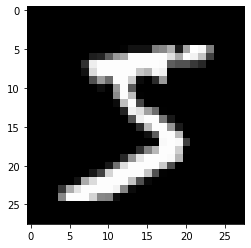

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
print("這個是:", y_train[0])
plt.imshow(x_train[0], cmap="gray")

In [5]:
# 中間層神經元數量選擇, 依照參數多寡決定 (1/10); 在這裡是28*28=784, 784/10=78 大概是64開始, 之後再繼續增加調整看看會不會增加正確率
# 輸出選擇, 一個用 sigmoid(0~1), 二個以上互斥用 softmax (加起來是1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # 中間層
model = Sequential()
# 64 個神經元 * 784 個 input params + 64 個 bias = 50240
model.add(Dense(64, activation="relu", input_dim=784)) # input: 28*28=784, 中間層 activation 必選 relu 系列避免梯度消失
 # 650個為, 64*10 個 input + 10 個 bias(讓激活函式平移統一規格, 讓及格分數統一)
model.add(Dense(10, activation="softmax")) #input 64, 不用特地告訴他
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss=CategoricalCrossentropy(),
             optimizer = "adam", # optimizer 梯度下降無腦選動量加速 "adam"
             metrics=["accuracy"])

In [7]:
# 預處理 categorical
# 類似 ML 的 one-hot-encoding
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print("原本: ", y_train[0]) # 數字 5
print("處理過: ", y_train_cat[0]) # 數字 5 的機率是 1

原本:  5
處理過:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
# tensorflow 規定輸入要做 nomalize to 0~1, 和隨機參數選擇有關(太大要調很久)
# 圖片: 1D -> /255 
x_train_norm = x_train.reshape(-1, 784) # -1: 自動計算輸入資料筆數 # 維度 28*28=784
x_test_norm = x_test.reshape(-1, 784) # 維度 28*28=784

x_train_norm.shape

(60000, 784)

In [9]:
# set batch_size: 看多少筆資料才做梯度下降 (多看幾張才調整)->節省時間 , 圖片不大:100-200, 大:10-20
# validation_split: 切出一部分作為驗證資料
# epochs: 整份資料集看多少遍
# verbose(進度條, 選用): 0(quiet),1,2
# 一個 epoch 做了 54000/200 = 270 次調整
# loss: cross entropy, 主要看 val_loss 有沒有下降, 單看 accuracy 可能會過擬合/過度訓練
model.fit(x_train_norm, 
          y_train_cat,
          batch_size=200,
         validation_split=0.1,
         epochs=20, # 這邊修改要重 run 要 restart run all, 不然會繼續 run 之前的
         verbose=2)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 - 2s - loss: 7.1575 - accuracy: 0.7529 - val_loss: 0.9081 - val_accuracy: 0.8095
Epoch 2/20
54000/54000 - 1s - loss: 0.8959 - accuracy: 0.8171 - val_loss: 0.5910 - val_accuracy: 0.8660
Epoch 3/20
54000/54000 - 1s - loss: 0.6081 - accuracy: 0.8652 - val_loss: 0.4923 - val_accuracy: 0.8857
Epoch 4/20
54000/54000 - 1s - loss: 0.4887 - accuracy: 0.8867 - val_loss: 0.4350 - val_accuracy: 0.9073
Epoch 5/20
54000/54000 - 1s - loss: 0.4029 - accuracy: 0.9039 - val_loss: 0.3972 - val_accuracy: 0.9133
Epoch 6/20
54000/54000 - 1s - loss: 0.3446 - accuracy: 0.9137 - val_loss: 0.3572 - val_accuracy: 0.9255
Epoch 7/20
54000/54000 - 1s - loss: 0.3021 - accuracy: 0.9223 - val_loss: 0.3300 - val_accuracy: 0.9282
Epoch 8/20
54000/54000 - 1s - loss: 0.2737 - accuracy: 0.9295 - val_loss: 0.3005 - val_accuracy: 0.9330
Epoch 9/20
54000/54000 - 1s - loss: 0.2435 - accuracy: 0.9345 - val_loss: 0.3053 - val_accuracy: 0.9328
Epoch 10/20
540

In [10]:
# 只要還在 tf 裡, 需要帶入 one-hot encoding
model.evaluate(x_test_norm, y_test_cat, verbose=2)

10000/1 - 1s - loss: 0.1243 - accuracy: 0.9509


[0.24721559344428243, 0.9509]

In [11]:
# predict: 機率 predict_classes: 分類
pre = model.predict_classes(x_test_norm)

# 不是在 tf 裡, 帶入原本的 y
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pre)
c = ["{}(預測)".format(i) for i in range(10)]
i = ["{}(真實)".format(i) for i in range(10)]
pd.DataFrame(mat, columns=c, index=i)

,0(預測),1(預測),2(預測),3(預測),4(預測),5(預測),6(預測),7(預測),8(預測),9(預測)
0(真實),961,0,3,1,2,4,2,1,6,0
1(真實),0,1116,3,1,1,1,2,1,9,1
2(真實),4,2,971,17,3,0,3,11,19,2
3(真實),4,3,11,947,2,19,0,8,10,6
4(真實),3,1,6,2,906,0,3,3,13,45
5(真實),9,0,0,23,1,842,5,1,9,2
6(真實),12,2,2,0,10,14,915,0,2,1
7(真實),3,3,11,7,5,1,0,979,3,16
8(真實),7,2,5,5,4,7,5,3,928,8
9(真實),8,7,0,5,21,5,0,6,13,944


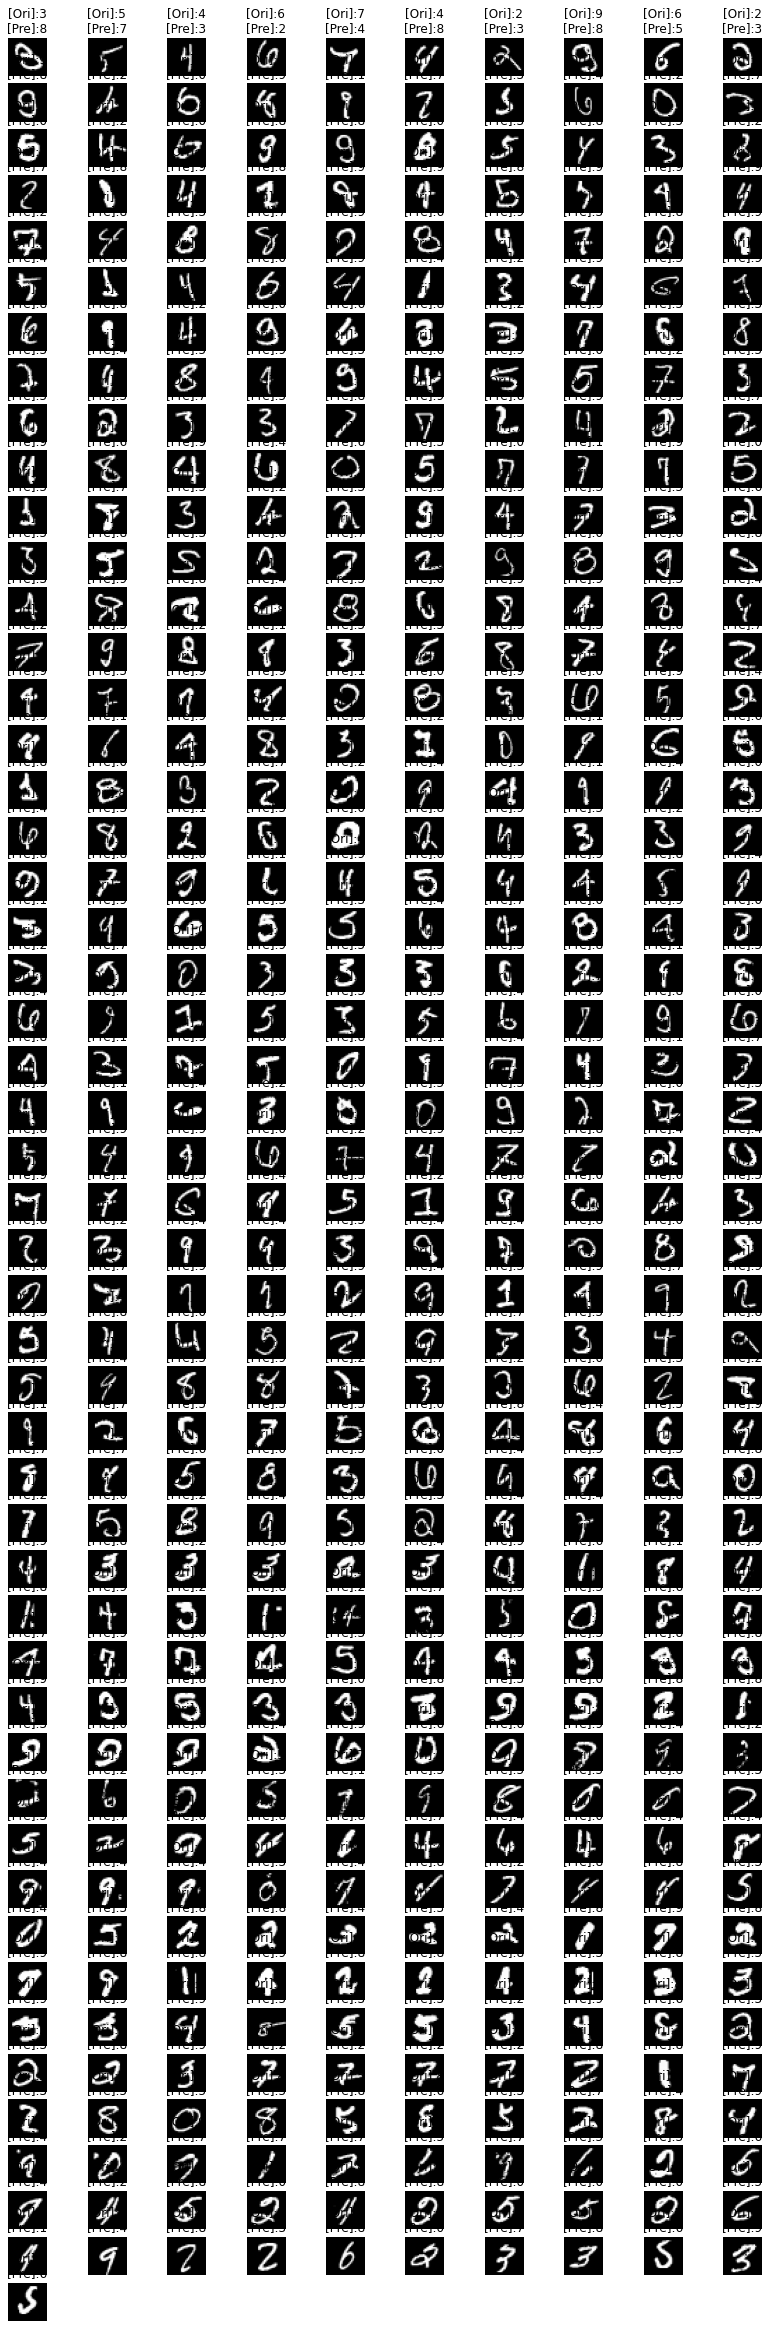

In [12]:
import numpy as np
# nonzero: 取出是 True 的 index
# (x 座標, y座標, z 座標)
idx = np.nonzero(pre != y_test)[0]
# 預測錯誤的圖
false_img = x_test[idx]
false_answer = y_test[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(14,42))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(false_answer[i],
                                    false_predict[i])
    plt.title(t)
    plt.imshow(img, cmap="gray")

輸入檔名:test.png
應該是: 8


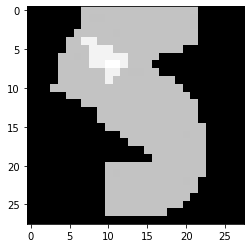

In [13]:
# import sys
# from PIL import Image
# sys.modules['Image'] = Image 
# from tensorflow.keras.preprocessing.image import load_img
# fn = input("輸入檔名:")
# img = load_img(fn, target_size=(28, 28)).convert("L")
# # 剛剛帶入 (10000, 784)
# # 現在帶入 (1,784)
# img_norm = np.array(img).reshape(1,784) / 255
# ans = model.predict_classes(img_norm)[0]
# print("應該是: ", ans)
# plt.imshow(img, cmap="gray")


from tensorflow.keras.preprocessing.image import load_img
fn = input("輸入檔名:")
img = load_img(fn, target_size=(28, 28)).convert("L")
# 剛剛帶入 (10000, 784)
# 現在帶入 (1, 784)
img_norm = np.array(img).reshape(1, 784) / 255
ans = model.predict_classes(img_norm)[0]
print("應該是:", ans)
plt.imshow(img, cmap="gray")